<a href="https://colab.research.google.com/github/ElenaBianchini/ColoringGrayscaleImages/blob/main/ProgettoLabIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto di Laboratorio di Intelligenza Artificiale e Grafica Interattiva**

# Import

In [1]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import color
from PIL import Image

# Impostazione dei parametri

In [5]:
num_epochs = 5
batch_size = 32
learning_rate = 1e-3
use_gpu = torch.cuda.is_available()

In [6]:
if use_gpu:
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

In [7]:
device

device(type='cpu')

# Paths

In [8]:
root_path = "/content/drive/MyDrive/COCO"

In [9]:
train_folder = root_path+"/train2014/"
val_folder = root_path+"/val2014/"
test_folder = root_path+"/test2014/"

# Dataset

In [10]:
def loadImagesName(dir_path, num):
    images_list = []
    count = 1
    for image_name in os.listdir(dir_path):
      if (count>num):
        break
      filename = os.path.join(dir_path, image_name)
      images_list.append(filename)
      print("\rImage num: {}".format(count), end='')
      count = count+1
    
    return images_list


In [19]:
train_list = loadImagesName(train_folder, 5000)

Image num: 5000

In [16]:
val_list = loadImagesName(val_folder, 2500)

Image num: 2500

In [15]:
test_list = loadImagesName(test_folder, 1875)

Image num: 1875

In [11]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images_list):
    self.images_list = images_list
    self.img_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
    ])

  def __len__(self):
    return len(self.images_list)
  
  def __getitem__(self, idx):
    img = Image.open(self.images_list[idx]).convert('RGB')
    img = self.img_transform(img)
    img = np.asarray(img)
    img_lab = color.rgb2lab(img) # restituisce un numpy
    img_lab = (img_lab + 128) / 255    # perché i valori dei canali ab del formato Lab vanno da -128 a 127 e li vogliamo tra [0,1]
    img_ab = img_lab[:, :, 1:3] # forma: WxHxC = [224, 224, 2]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    img_gray = color.rgb2gray(img)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    img = torch.from_numpy(img.transpose((2, 0, 1))).float()
    return img, img_ab, img_gray


In [20]:
train_dataset = ImageDataset(train_list)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
val_dataset = ImageDataset(val_list)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [22]:
test_dataset = ImageDataset(test_list)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for i, (img, img_ab, img_gray) in enumerate(test_dataloader):
  gray = img_gray[0].squeeze().numpy()
  ab = img_ab[0].numpy().transpose(1,2,0)
  real = img[0].numpy().transpose(1,2,0).astype(int)
  f, ax = plt.subplots(1,2)
  f.set_size_inches(15, 15)
  ax[0].imshow(gray, cmap='gray')
  #ax[1].imshow(ab)
  ax[1].imshow(real)
  ax[0].axis('off'),ax[1].axis('off')
  plt.show()
  break

# Regressione

## Modello

In [24]:
class ColorizationRNet(nn.Module):
  def __init__(self, input_size = 128):
    super(ColorizationRNet, self).__init__()

    # Importo ResNet che userò per estrarre le features dalle immagini
    resnet = torchvision.models.resnet18()
    # Cambio il primo livello di convoluzione di ResNet per accetta input con un solo canale
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Estraggo le feature dalle immagini
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    # Livelli di deconvoluzione:
    self.deconv = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
    )

  def forward(self, x):
    x = self.midlevel_resnet(x)
    output = self.deconv(x)
    return output

In [25]:
reg_net = ColorizationRNet()
reg_net = reg_net.to(device)

## Funzione di costo e di ottimizzazione

In [26]:
optimizer = torch.optim.Adam(params=reg_net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
criterion = criterion.to(device)

## Train

In [27]:
def train(epoch, loss_avg):
  # Set model to training model
  reg_net.train()

  print('\nStarting training epoch {}\n'.format(epoch))

  loss_avg.append(0)

  for batch_idx, (img, img_ab, img_gray) in enumerate(train_dataloader):
    img = img.to(device)
    img_ab = img_ab.to(device)
    img_gray = img_gray.to(device)

    # Predizione dell'immagine ab da grayscale
    predicted = reg_net(img_gray)
  
    # Calcolo l'errore L2 tra i colori ottenuti e quelli veri:
    loss = criterion(predicted, img_ab)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Aggiorno i pesi:
    optimizer.step()

    loss_avg[-1]+=loss.item()

    if batch_idx % 20 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.6f}'.format(
            epoch, batch_idx*len(img), len(train_dataloader.dataset), 100. * batch_idx / len(train_dataloader), loss.item()))

  loss_avg[-1]/= batch_size
  print('\nFinished training epoch {}\n'.format(epoch))


## Validation

In [28]:
def validation(epoch, val_loss_avg):
  # Set model to validation model
  reg_net.eval()

  val_loss_avg.append(0)

  for batch_idx, (img, img_ab, img_gray)in enumerate(val_dataloader):
    img = img.to(device)
    img_ab = img_ab.to(device)
    img_gray = img_gray.to(device)

    # Predizione dell'immagine ab da grayscale
    predicted = reg_net(img_gray)

    # Calcolo l'errore L2 tra i colori ottenuti e quelli veri:
    loss = criterion(predicted, img_ab)
    val_loss_avg[-1]+=loss.item()

    if batch_idx % 50 == 0:
        print('Validation Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.6f}'.format(
            epoch, batch_idx*len(img), len(val_dataloader.dataset), 100. * batch_idx / len(val_dataloader), loss.item()))

    # Salvo la prima foto di ogni epoca
    if batch_idx==0: 
      plt.clf() #clear matplotlib
      input_gray = img_gray[0].cpu().squeeze().numpy()
      output_color = torch.cat((img_gray[0].cpu(), predicted[0].detach().cpu()), 0).numpy()
      output_color = output_color.transpose((1,2,0))
      output_color[:, :, 0:1] = output_color[:, :, 0:1] * 100
      output_color[:, :, 1:3] = output_color[:, :, 1:3] * 255 - 128   
      output_color = color.lab2rgb(output_color.astype(np.float64))
      real_color = img[0].cpu().numpy().transpose((1,2,0)).astype(np.uint8)
      plt.imsave(arr=input_gray, fname = '/content/drive/MyDrive/ProgettoLab/immagini/{}_grayscale.jpg'.format(epoch),  cmap='gray')
      plt.imsave(arr=output_color, fname = '/content/drive/MyDrive/ProgettoLab/immagini/{}_recolored.jpg'.format(epoch))
      plt.imsave(arr=real_color, fname = '/content/drive/MyDrive/ProgettoLab/immagini/{}_real.jpg'.format(epoch))


  val_loss_avg[-1]/= batch_size
  print('\nValidation set: Average loss: {:.4f}\n'.format(val_loss_avg[-1]))
  return val_loss_avg[-1]


## Allenamento

In [29]:
best_losses = 1.0
train_loss_avg = []
val_loss_avg = []

for epoch in range(1, num_epochs+1):
  train(epoch, train_loss_avg)
  losses = validation(epoch, val_loss_avg)

  if losses < best_losses:
    best_losses = losses
    torch.save(reg_net.state_dict(), '/content/drive/MyDrive/ProgettoLab/checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))



Starting training epoch 1

Train Epoch: 1 [0/5000 (0%)]  Loss: 0.806074
Train Epoch: 1 [384/5000 (8%)]  Loss: 0.014501
Train Epoch: 1 [768/5000 (15%)]  Loss: 0.008515
Train Epoch: 1 [1152/5000 (23%)]  Loss: 0.005361
Train Epoch: 1 [1536/5000 (31%)]  Loss: 0.008549
Train Epoch: 1 [1920/5000 (38%)]  Loss: 0.007133
Train Epoch: 1 [2304/5000 (46%)]  Loss: 0.008466
Train Epoch: 1 [2688/5000 (54%)]  Loss: 0.005647
Train Epoch: 1 [3072/5000 (61%)]  Loss: 0.004737
Train Epoch: 1 [3456/5000 (69%)]  Loss: 0.004152
Train Epoch: 1 [3840/5000 (76%)]  Loss: 0.004863
Train Epoch: 1 [4224/5000 (84%)]  Loss: 0.004950
Train Epoch: 1 [4608/5000 (92%)]  Loss: 0.004272
Train Epoch: 1 [1248/5000 (99%)]  Loss: 0.004745

Finished training epoch 1

Validation Epoch: 1 [0/2500 (0%)]  Loss: 0.004605
Validation Epoch: 1 [1600/2500 (63%)]  Loss: 0.004930

Validation set: Average loss: 0.0112


Starting training epoch 2

Train Epoch: 2 [0/5000 (0%)]  Loss: 0.004698
Train Epoch: 2 [384/5000 (8%)]  Loss: 0.003270
Tr

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validation Epoch: 3 [1600/2500 (63%)]  Loss: 0.004846

Validation set: Average loss: 0.0102


Starting training epoch 4

Train Epoch: 4 [0/5000 (0%)]  Loss: 0.004004
Train Epoch: 4 [384/5000 (8%)]  Loss: 0.004740
Train Epoch: 4 [768/5000 (15%)]  Loss: 0.003464
Train Epoch: 4 [1152/5000 (23%)]  Loss: 0.003628
Train Epoch: 4 [1536/5000 (31%)]  Loss: 0.002309
Train Epoch: 4 [1920/5000 (38%)]  Loss: 0.004487
Train Epoch: 4 [2304/5000 (46%)]  Loss: 0.003883
Train Epoch: 4 [2688/5000 (54%)]  Loss: 0.003985
Train Epoch: 4 [3072/5000 (61%)]  Loss: 0.003718
Train Epoch: 4 [3456/5000 (69%)]  Loss: 0.003280
Train Epoch: 4 [3840/5000 (76%)]  Loss: 0.003973
Train Epoch: 4 [4224/5000 (84%)]  Loss: 0.003174
Train Epoch: 4 [4608/5000 (92%)]  Loss: 0.003728
Train Epoch: 4 [1248/5000 (99%)]  Loss: 0.003391

Finished training epoch 4

Validation Epoch: 4 [0/2500 (0%)]  Loss: 0.004155
Validation Epoch: 4 [1600/2500 (63%)]  Loss: 0.002964

Validation set: Average loss: 0.0091


Starting training epoch 5

T

<Figure size 432x288 with 0 Axes>

## Grafico della curva di apprendimento

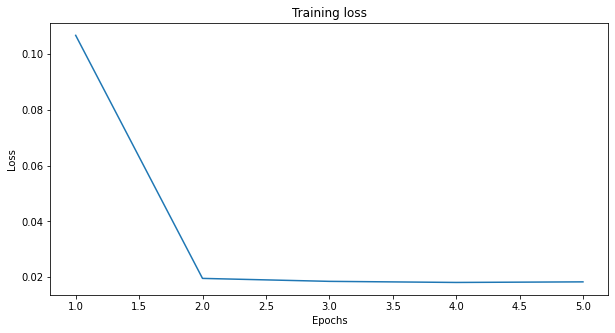

In [30]:
plt.ion()
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs+1),train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

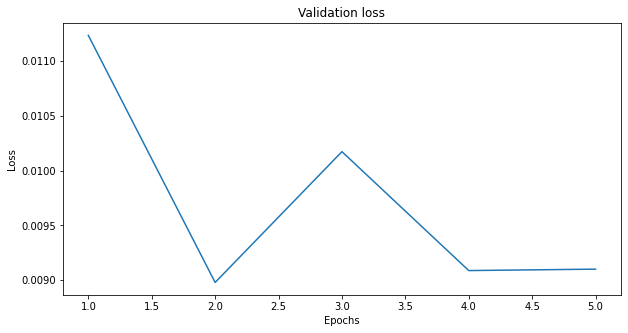

In [31]:
plt.ion()
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs+1), val_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.show()

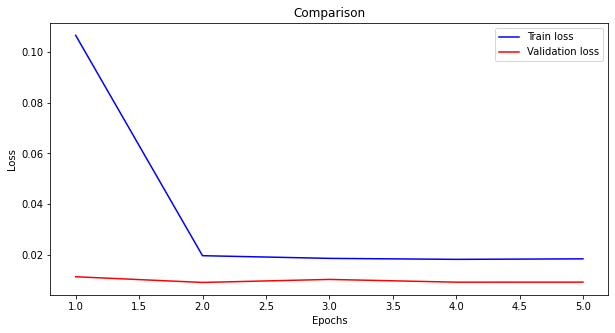

In [40]:
plt.ion()
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs+1),train_loss_avg, 'b', label='Train loss')
plt.plot(np.arange(1, num_epochs+1), val_loss_avg, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison')
plt.legend()
plt.show()

In [37]:
print(train_loss_avg)
print(val_loss_avg)

[0.10664669604011578, 0.019554675862309523, 0.01849516177753685, 0.018104530827258714, 0.018312830266950186]
[0.011235574282181915, 0.008980071877886076, 0.010173873029998504, 0.009088498787605204, 0.009101527255552355]


## Risultato su un'immagine del Test Set

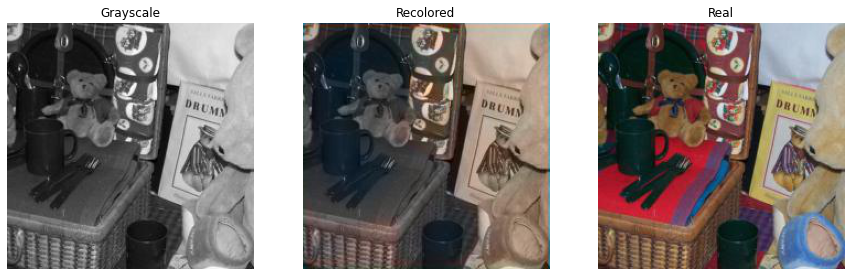

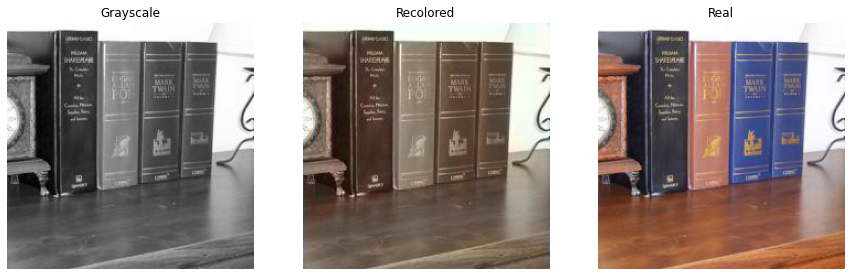

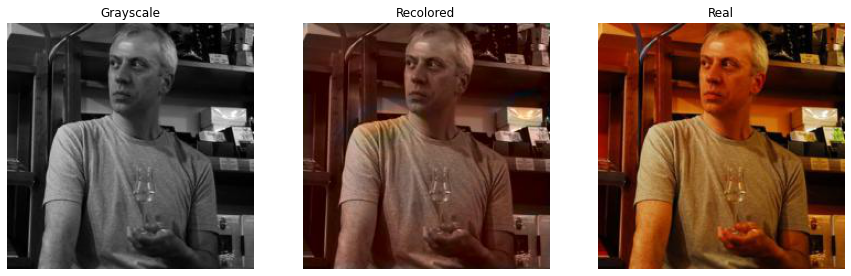

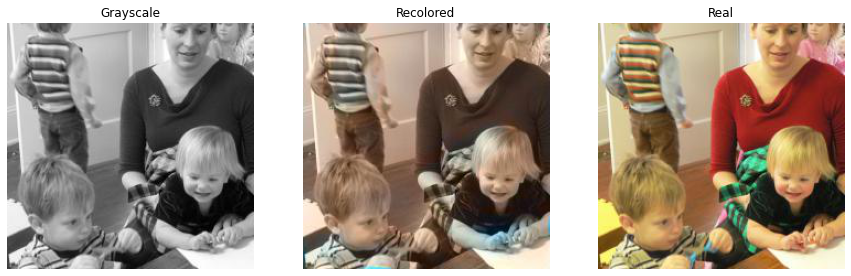

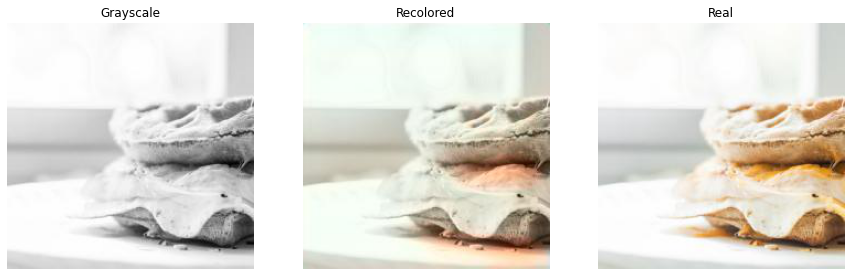

In [41]:
path = '/content/drive/MyDrive/ProgettoLab/immagini/'

for i in range(1,6):
  gray = Image.open(path+'{}_grayscale.jpg'.format(i))
  recolored = Image.open(path+'{}_recolored.jpg'.format(i))
  real = Image.open(path+'{}_real.jpg'.format(i))

  f, ax = plt.subplots(1,3)
  f.set_size_inches(15, 15)

  ax[0].imshow(gray, cmap='gray')
  ax[0].set_title('Grayscale')

  ax[1].imshow(recolored)
  ax[1].set_title('Recolored')

  ax[2].imshow(real)
  ax[2].set_title('Real')

  ax[0].axis('off'),ax[1].axis('off'), ax[2].axis('off')

  plt.show()